In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [2]:
data_path = r'data/clean_df.csv.gz'
df = pd.read_csv(data_path).drop('Unnamed: 0', axis=1)
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,DISTANCE FROM MADISON SQUARE GARDEN,DISTANCE FROM PORT AUTHORITY,DISTANCE FROM GRAND ARMY PLAZA,DISTANCE FROM TRIBECA,DISTANCE FROM BATTERY PARK,DISTANCE FROM SOHO,DISTANCE FROM CONEY ISLAND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4
0,2017-06-26 00:00:00,2020-09-22 22:00:00,MANHATTAN,10002.0,40.718270,-73.99072,POINT (-73.99072 40.71827),ALLEN STREET,BROOME STREET,NaN,...,0.032134,0.038880,0.051023,0.017988,0.029482,0.013270,0.144167,176 days,-182 days,-8 days
1,2017-07-14 00:00:00,2020-09-22 13:17:00,NaN,10028.0,40.783180,-73.94362,POINT (-73.94362 40.78318),FDR DRIVE,NaN,NaN,...,0.059596,0.054004,0.113396,0.093249,0.107943,0.084330,0.209438,194 days,-164 days,10 days
2,2017-07-04 00:00:00,2020-09-22 14:00:00,BRONX,10462.0,40.833557,-73.85774,POINT (-73.85774 40.833557),WESTCHESTER AVENUE,PUGSLEY AVENUE,NaN,...,0.159107,0.153556,0.195316,0.191071,0.205098,0.182365,0.281697,184 days,-174 days,0 days
3,2017-07-17 00:00:00,2020-09-22 21:03:00,MANHATTAN,10032.0,40.833843,-73.94851,POINT (-73.94851 40.833843),RIVERSIDE DRIVE,WEST 155 STREET,NaN,...,0.094805,0.087647,0.162559,0.132012,0.147135,0.123243,0.259294,197 days,-161 days,13 days
4,2017-06-26 00:00:00,2020-09-22 15:35:00,BROOKLYN,11203.0,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVENUE,LINDEN BOULEVARD,NaN,...,0.119852,0.124044,0.050176,0.106925,0.106393,0.106784,0.093070,176 days,-182 days,-8 days


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486656 entries, 0 to 1486655
Data columns (total 54 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   CRASH DATE                           1486656 non-null  object 
 1   CRASH TIME                           1486656 non-null  object 
 2   BOROUGH                              1143388 non-null  object 
 3   ZIP CODE                             1486656 non-null  float64
 4   LATITUDE                             1486656 non-null  float64
 5   LONGITUDE                            1486656 non-null  float64
 6   LOCATION                             1486656 non-null  object 
 7   ON STREET NAME                       1203377 non-null  object 
 8   CROSS STREET NAME                    980930 non-null   object 
 9   OFF STREET NAME                      221574 non-null   object 
 10  NUMBER OF PERSONS INJURED            1486641 non-null  float64
 11

In [4]:
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

<AxesSubplot:>

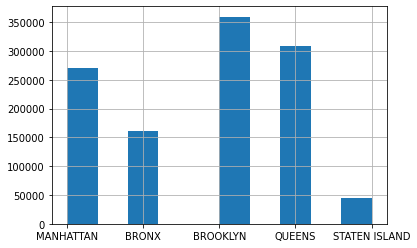

In [5]:
df['BOROUGH'].hist()

A lot more accidents in Brooklyn and Queens than in Manhattan. Unexpected. Let's examine each of those boroughs and determine if there are specific "danger areas."

In [6]:
brooklyn = df.loc[df['BOROUGH'] == 'BROOKLYN',:]
brooklyn.loc[:,'ON STREET NAME'] = brooklyn.loc[:,'ON STREET NAME'].apply(lambda x: str(x).rstrip())

/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


##### Create a table that examines the number of accidents on a street, divided by the max Euclidean distance between the furthest accidents. You can do this by creating a Euclidean distance for each accident from (0,0) and taking the max for that column for each street name.

### Accidents pivot table

In [7]:
lat_range = brooklyn.groupby('ON STREET NAME')['LATITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LATITUDE'].min()
lon_range = brooklyn.groupby('ON STREET NAME')['LONGITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LONGITUDE'].min()
straight_range = np.sqrt(lat_range ** 2 + lon_range ** 2)

In [8]:
brooklyn['RANGE'] = brooklyn['ON STREET NAME'].apply(lambda x: straight_range[x])

<ipython-input-8-b3dd9c50587e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn['RANGE'] = brooklyn['ON STREET NAME'].apply(lambda x: straight_range[x])


In [9]:
straight_range.sort_values(ascending=False)

ON STREET NAME
nan                     0.590046
ATLANTIC AVENUE         0.427423
3 AVENUE                0.331295
60 STREET               0.290725
FLATBUSH AVENUE         0.269701
                          ...   
CROSBY PLACE            0.000000
CUMBERLAND WALK         0.000000
CYPRESS COURT           0.000000
CYPRESS HILLS STREET    0.000000
DARE COURT              0.000000
Length: 1699, dtype: float64

In [10]:
casualties = brooklyn.groupby('ON STREET NAME')['TOTAL PEDESTRIAN CASUALTIES'].sum()
casualties.sort_values(ascending=False)

ON STREET NAME
nan                   4541
BEDFORD AVENUE         592
FLATBUSH AVENUE        574
ATLANTIC AVENUE        569
NOSTRAND AVENUE        563
                      ... 
PILLING STREET           0
CANTON COURT             0
KNICKERBOCK AVENUE       0
CANARSIE LANE            0
CATON PLACE              0
Name: TOTAL PEDESTRIAN CASUALTIES, Length: 1699, dtype: int64

In [11]:
street_count = brooklyn.groupby('ON STREET NAME')['COLLISION_ID'].count()
street_count

ON STREET NAME
                         4
 Wallabout Street        1
 williams avenue         1
1 AVENUE               116
1 COURT                  5
                     ...  
Winthrop St              1
Wythe Ave                1
YORK STREET             87
flatlands avenue         1
nan                  70669
Name: COLLISION_ID, Length: 1699, dtype: int64

In [12]:
streets = pd.DataFrame({'# ACCIDENTS':street_count, 'MAP RANGE':straight_range, 'CASUALTIES':casualties},
                              index=straight_range.index)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
nan,70669,0.590046,4541
BEDFORD AVENUE,3908,0.197446,592
FLATBUSH AVENUE,6427,0.269701,574
ATLANTIC AVENUE,9473,0.427423,569
NOSTRAND AVENUE,4082,0.164418,563
FULTON STREET,3035,0.241355,500
5 AVENUE,1926,0.086465,480
OCEAN AVENUE,2764,0.168181,398
CHURCH AVENUE,2548,0.099609,386


In [13]:
streets = streets.drop(streets.sort_values('CASUALTIES', ascending=False).index[0], axis=0)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
BEDFORD AVENUE,3908,0.197446,592
FLATBUSH AVENUE,6427,0.269701,574
ATLANTIC AVENUE,9473,0.427423,569
NOSTRAND AVENUE,4082,0.164418,563
FULTON STREET,3035,0.241355,500
5 AVENUE,1926,0.086465,480
OCEAN AVENUE,2764,0.168181,398
CHURCH AVENUE,2548,0.099609,386
UTICA AVENUE,3676,0.069118,381


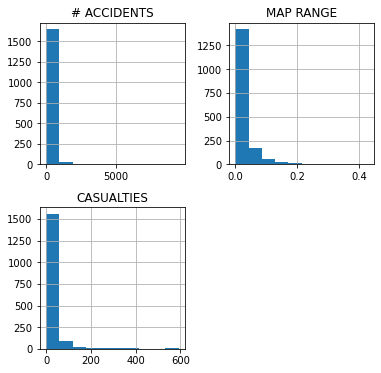

In [14]:
_ = streets.hist(figsize=(6,6))

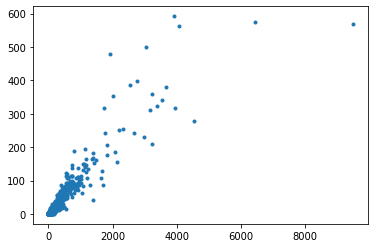

In [15]:
_ = plt.plot(streets['# ACCIDENTS'], streets['CASUALTIES'], marker='.', linestyle='none')

In [16]:
streets.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.682559,0.926981
MAP RANGE,0.682559,1.000000,0.645612
CASUALTIES,0.926981,0.645612,1.000000


Atlantic Ave is clearly an outlier with regard to number of accidents and number of casualties (since those are highly correlated, this is not a surprise). Is it related to the fact that the street is longer than most others?

In [17]:
map_head = streets.sort_values('MAP RANGE', ascending=False).head(50)
map_head.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
ATLANTIC AVENUE,9473,0.427423,569
3 AVENUE,2986,0.331295,230
60 STREET,1117,0.290725,150
FLATBUSH AVENUE,6427,0.269701,574
PROSPECT EXPRESSWAY,16,0.263285,1


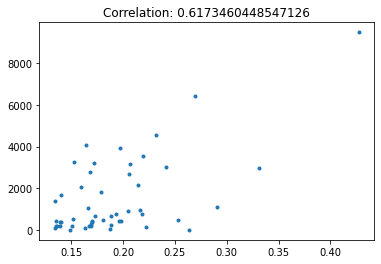

In [18]:
_ = plt.plot(map_head['MAP RANGE'], map_head['# ACCIDENTS'], marker='.', linestyle='none')
_ = plt.title('Correlation: {}'.format(map_head['MAP RANGE'].corr(map_head['# ACCIDENTS'])))

While a single accident may occur on a street, we are more interested in patterns. As such, we should consider dropping records where `# ACCIDENTS` equals 1.

In [19]:
len(streets[streets['# ACCIDENTS'] < 10])

568

In [20]:
more_accidents = streets[streets['# ACCIDENTS'] >= 10]
more_accidents.sort_values('# ACCIDENTS', ascending=True).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
CYRUS AVENUE,10,0.003016,1
ARLINGTON PLACE,10,0.000753,1
SAINT PAULS COURT,10,0.001479,2
EAST 106 STREET,10,0.002479,0
FORREST STREET,10,0.005552,0
SOUTH 5 PLACE,10,0.148811,7
LAMONT COURT,10,0.001374,1
FRIEL PLACE,10,0.002299,0
OVERBAUGH PLACE,10,0.001732,1


In [21]:
more_accidents.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.668530,0.922393
MAP RANGE,0.668530,1.000000,0.626164
CASUALTIES,0.922393,0.626164,1.000000


##### Add daytime and weekend data to `more_accidents`

In [22]:
daytime_weekend = df.groupby('ON STREET NAME')[['WEEKEND', 'DURING DAYTIME']].sum()
dt_wk_streets = more_accidents.join(daytime_weekend, how='right')

In [23]:
dt_wk_streets.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES,WEEKEND,DURING DAYTIME
ON STREET NAME,,,,,
,NaN,NaN,NaN,2,10
Harlem River Dr,NaN,NaN,NaN,0,1
Main Ave,NaN,NaN,NaN,0,0
Wallabout Street,NaN,NaN,NaN,0,1
williams avenue,NaN,NaN,NaN,0,1


Where are the accidents that don't have street labels? Maybe they're on major highways.

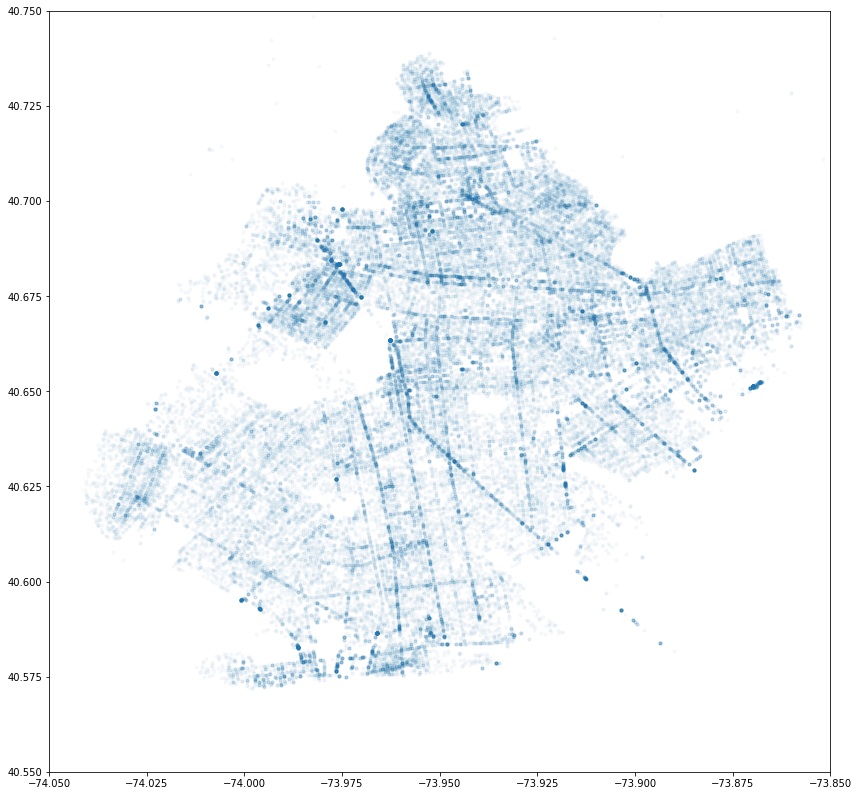

In [24]:
no_streets = df[(df['ON STREET NAME'].isnull() == True) & (df['BOROUGH'] == 'BROOKLYN')]

_ = plt.figure(figsize=(14,14))
_ = plt.plot(no_streets['LONGITUDE'], no_streets['LATITUDE'], marker='.', linestyle='none', alpha=0.03)
_ = plt.xlim(-74.05, -73.85)
_ = plt.ylim(40.55, 40.75)
plt.show()

### Hourly plots

##### Hourly data by borough

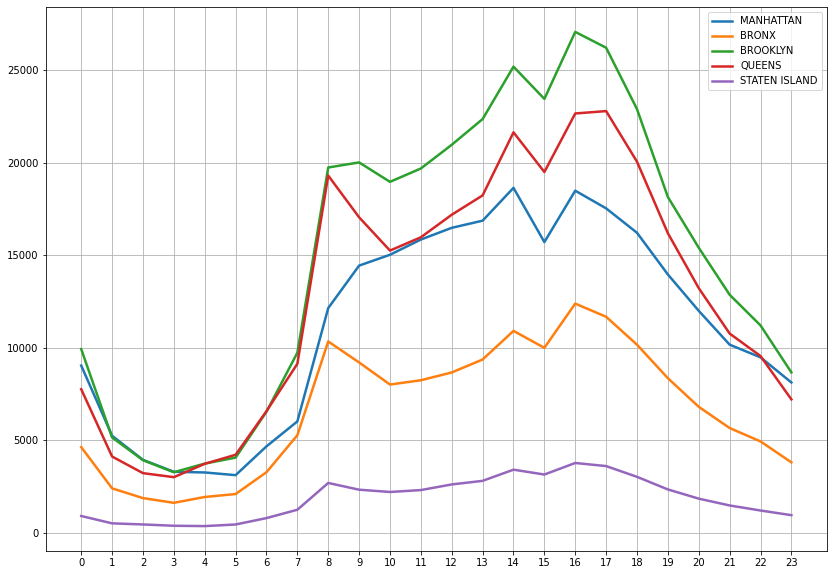

In [25]:
boroughs = df['BOROUGH'].dropna().unique()
plt.figure(figsize=(14,10))
for borough in boroughs:
    hours = df.loc[(df['BOROUGH'] == borough) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(boroughs)

1. Manhattan and the Bronx have a spike at 8 AM. Brooklyn hits that same high, but doesn't taper off afterwards. Manhattan doesn't spike at 8 AM at all.
2. All dip at 3 PM and spike at 4 PM then taper into the evenings.

##### Hourly data by day

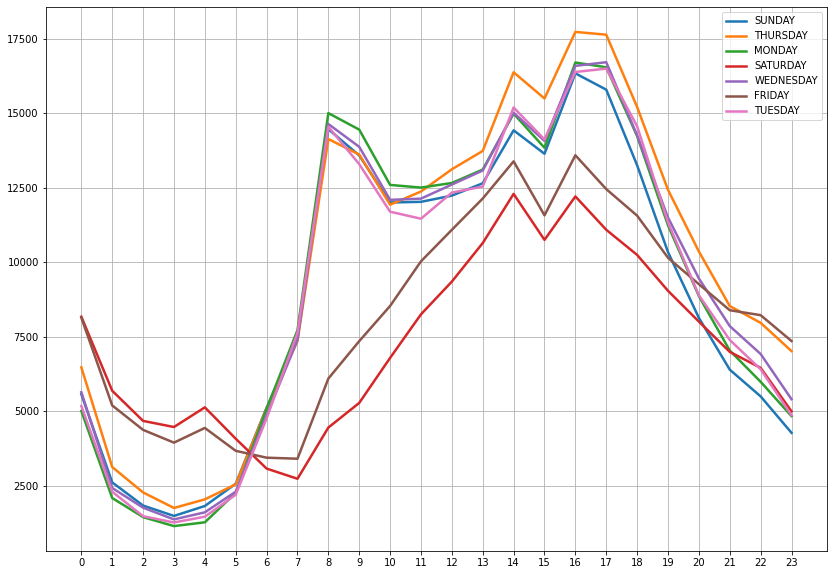

In [26]:
days = df['WEEKDAY'].unique()
plt.figure(figsize=(14,10))
for day in days:
    hours = df.loc[(df['WEEKDAY'] == day) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(days)

1. Friday doesn't have an early morning spike.
2. There's always a dip at 3 PM.
3. The afternoon rush-hour spike is larger than the morning rush-hour spike.

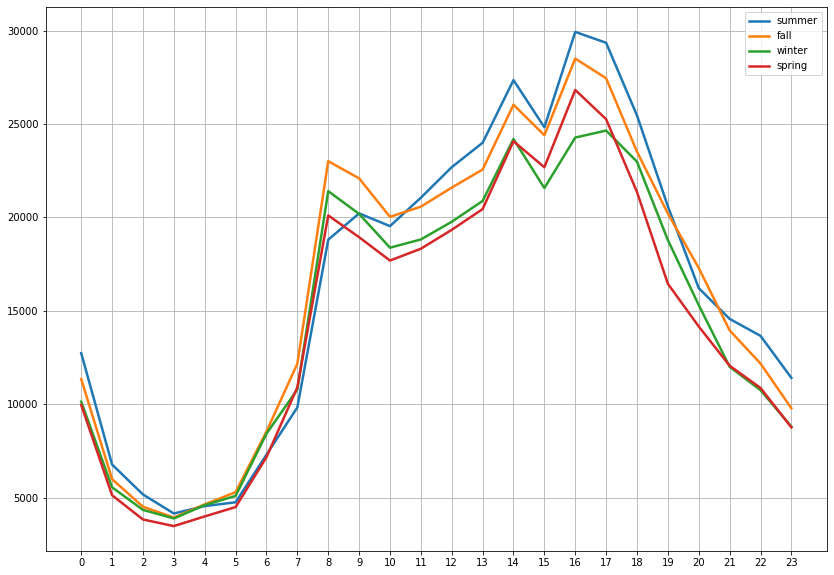

In [27]:
seasons = df['SEASON'].unique()
plt.figure(figsize=(14,10))
for season in seasons:
    hours = df.loc[(df['SEASON'] == season) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    

    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(seasons)

1. The data follows the same trend in each season.
2. There are more fall accidents than winter accidents in the morning.
3. There are the fewest summer accidents in the morning but the most in the evening.
4. Winter's accidents are second-highest in the morning but extemely low in the evening.

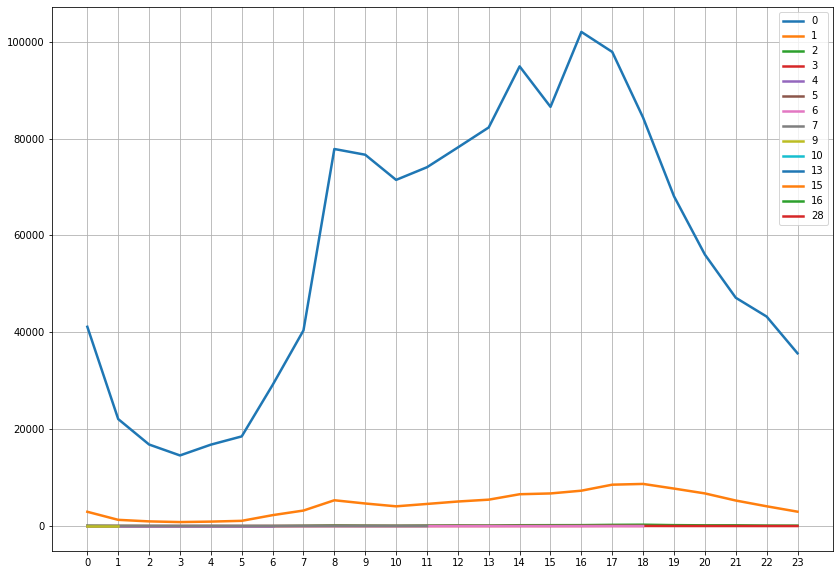

In [28]:
casualties = df['TOTAL PEDESTRIAN CASUALTIES'].unique()
plt.figure(figsize=(14,10))
for number in casualties:
    hours = df.loc[(df['TOTAL PEDESTRIAN CASUALTIES'] == number) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['COLLISION_ID'].count()
    

    _ = plt.plot(range(0,len(hours)), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
#     _ = plt.ylim(0,4500)
_ = plt.grid()
_ = plt.legend(np.sort(casualties))

In [ ]:
_ = plt.hist(df['LONGITUDE'])

In [ ]:
_ = plt.hist(df['LATITUDE'])

In [ ]:
boroughs = ['MANHATTAN','BRONX','BROOKLYN','STATEN ISLAND','QUEENS']
_ = plt.plot(df['LONGITUDE'], df['LATITUDE'], 'k.', alpha=0.01)
for borough in boroughs:
    df_borough = df[df['BOROUGH'] == borough]
    _ = plt.plot(df_borough['LONGITUDE'].mean(), df_borough['LATITUDE'].mean(), 'or')

In [ ]:
for borough in boroughs:
    df_borough = df['BOROUGH'] == borough
    borough_lat_mean = df.loc[df_borough,'LATITUDE'].mean()
    borough_lon_mean = df.loc[df_borough,'LONGITUDE'].mean()
    lon_distance = (df.loc[df_borough,'LONGITUDE'] - borough_lon_mean) ** 2
    lat_distance = (df.loc[df_borough,'LATITUDE'] - borough_lat_mean) ** 2
    df.loc[df_borough,'DISTANCE FROM MEAN'] = np.sqrt(lon_distance + lat_distance)

In [ ]:
no_borough = df[df['BOROUGH'].isnull() == True]
_ = plt.figure(figsize=(40,40))
_ = sns.scatterplot(x='LONGITUDE',
                    y='LATITUDE',
                    data=no_borough,
                    hue=no_borough['CRASH DATE'].dt.year,
                    cmap='hus1',
                    alpha=0.1)

Null data seems to focus on the borders and through-streets. Are those highways?

In [ ]:
no_borough['ON STREET NAME'].value_counts()[lambda x:x>1000]

In [ ]:
geo_features = [name for name in df.columns if 'DISTANCE FROM' in name]
for feature in geo_features:
    plt.hist(df[feature])
    plt.title(feature)
    plt.show()

I don't know why, but all the distances have different shapes. That seems very strange. Particularly odd is the `DISTANCE FROM CONEY ISLAND`, which has a normal (rather than Poisson) distribution, and `DISTANCE FROM BRONX ZOO`, which has a spike at around 0.16. Notably, these are the two geo features whose distances are outside Manhattan. This may contribute to the unusual spike.

In [ ]:
top_counts = df.groupby('DAYS FROM NEW YEARS')['DAYS FROM NEW YEARS'].count()
_ = plt.scatter(top_counts.index, top_counts, marker='.')
_ = plt.title('Number of accidents by day')
_ = plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,   
    top=False,         
    labelbottom=False) 
_ = plt.show()

In [ ]:
top_counts[top_counts < 3000]

In [ ]:
top_counts.describe()

There is a particular dip around Christmas and New Years. This is to be expected. It is surprising that New Years is relatively so high.

In [ ]:
# df.to_csv(r'data/modeling_df.csv.gz')